# REI505M Machine Learning - Final project
### Due: --------

**Names**: Axel Kristján Axelsson, Bjarni Haukur Bjarnason <br />
**Email**: aka30@hi.is, bhb23@hi.is

**1. Image classification**

s


In [73]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_io as tfio
tf.executing_eagerly()


from data_loader import MyDataLoader
from neural_nets import NeuralNets
from helper_funcs import *
from my_dataset import parse_to_image, parse_to_array, parse_and_augment

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


%load_ext autoreload 
%autoreload 2

norm = (128,128)

dl = MyDataLoader("combine3", norm)
nn = NeuralNets(norm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
def create_dataset_from_files(filenames, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.shuffle(buffer_size=len(filenames))#.repeat(REPEAT_COUNT)
    if augment:
        ds = ds.map(parse_and_augment, num_parallel_calls=WORKERS)
    else:
        ds = ds.map(parse_to_image, num_parallel_calls=WORKERS)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def create_dataset_from_array(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    #ds = ds.shuffle(buffer_size=X.shape[0])#.repeat(REPEAT_COUNT)
    # ds = ds.repeat()
    # ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [75]:
import math

# filenames = dl.get_all_filenames()
# val_files = filenames[index_arr1]
# train_files = np.delete(filenames, index_arr1)
# test_files = train_files[index_arr2]
# train_files = np.delete(train_files, index_arr2)
# NUM_FILES = len(filenames)
# index_arr1 = np.random.choice(NUM_FILES, VAL_SIZE)
# index_arr2 = np.random.choice(NUM_FILES-VAL_SIZE, TEST_SIZE)

train_files = dl.numpy_load("train_files")
test_files  = dl.numpy_load("test_files")
val_files   = dl.numpy_load("val_files")

BATCH_SIZE = 64
WORKERS    = 16
TEST_SIZE  = test_files.shape[0]
VAL_SIZE   = val_files.shape[0]
TRAIN_SIZE = train_files.shape[0]
NUM_FILES  = TEST_SIZE + VAL_SIZE + TRAIN_SIZE






NUM_TRAIN_STEPS = math.floor(TRAIN_SIZE/BATCH_SIZE)
NUM_VAL_STEPS   = math.floor(VAL_SIZE/BATCH_SIZE)

ds_train = create_dataset_from_files(train_files, augment=True)
ds_val   = create_dataset_from_files(val_files, augment=True)
ds_test  = create_dataset_from_files(test_files)
# ds_test  = create_dataset_frofilesay(X_test, y_test)


# ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

# ds_train = ds_train.prefetch(PREFETCH_SIZE)

# ds_val   = ds.skip(TEST_SIZE).take(VAL_SIZE)
# ds_train = ds.skip(TEST_SIZE + VAL_SIZE)

# ds_train = ds_train.batch(BATCH_SIZE)

In [76]:
def SSIMLoss(y_true, y_pred):
  return 0.5*(1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)))+0.5*tf.keras.metrics.mean_squared_error(y_true,y_pred)

In [78]:
model = nn.model_i()
model.compile(optimizer='rmsprop', loss=SSIMLoss, metrics=["accuracy"])
log_dir = "logs/fit/" + "model_i"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 128)     

In [ ]:
from random import randint


num_iters = 20

test_images = ds_test.as_numpy_iterator().next()


history_arr = np.ndarray(shape=(num_iters,), dtype=object)
for i in range(num_iters):
    history_arr[i] = model.fit(ds_train, epochs=5, steps_per_epoch=NUM_TRAIN_STEPS, validation_data=ds_val, validation_steps=NUM_VAL_STEPS, callbacks=[tensorboard_callback])
    
    if i%2==0:
        save_model(model, f"model_i_SSIM{i}", brave=True)

    img_number = randint(0, BATCH_SIZE)
    img = np.expand_dims(test_images[0][img_number], 0)
    pred = model.predict(img)
    save_images(img , map_from(pred), name="model_i_SSIM", enumerate=i)

In [11]:
save_model(model, "model_h_SSIM19")

INFO:tensorflow:Assets written to: c:\Skoli\Haust2021\Lokaverkefni\GG-Lokaverkefni\models\model_h_SSIM19\assets


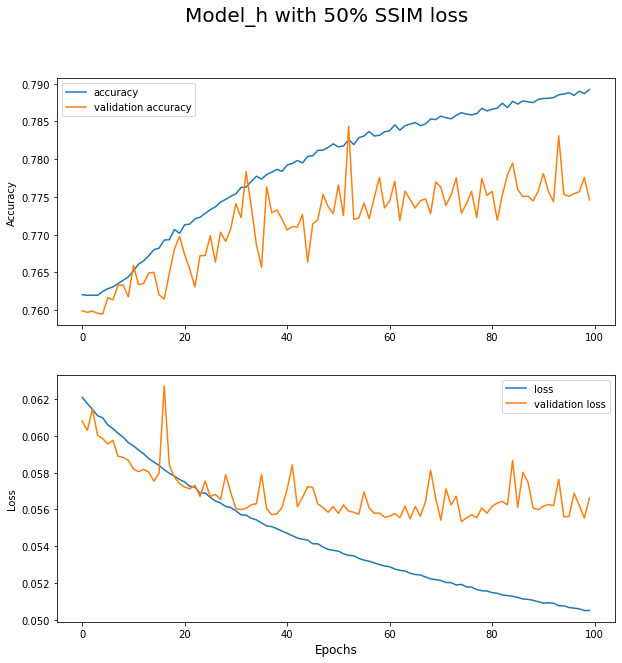

In [12]:
from matplotlib import pyplot as plt
from helper_funcs import *

# new_arr = np.ndarray(shape=(30,), dtype=object)
# new_arr[:10] = history_arr
# new_arr[10:] = history_arr2

plot_acc_and_loss(history_arr, title="Model_h with 50% SSIM loss", name="model_h_SSIM", save=True, figsize=(10,10))


In [95]:
model = load_model("model_h_SSIM6", custom={'SSIMLoss':SSIMLoss})

In [101]:
####################################################################################
# model_e14 frekar gott general skill, model_e40 gott en of miklir litir
####################################################################################


from skimage import color
# save_model(model, "model_e40")

# img_numbers = np.random.choice(size, 5)
# test_image = X_test[img_numbers]
iter = ds_test.as_numpy_iterator()
test_image = iter.next()

num_images = 4

grey = test_image[0][:num_images]
ab   = test_image[1][:num_images]

none_arr = np.zeros(shape=(num_images, norm[0], norm[1], 2))

pred = model.predict(grey)
show_images(grey, none_arr)
show_images(grey, map_from(pred), enhance=1.2)
show_images(grey, map_from(ab))


In [132]:
from gan import *
from IPython.display import clear_output

cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real, disc_fake):
    real_loss = cross_entropy(tf.ones_like(disc_real), disc_real)
    fake_loss = cross_entropy(tf.zeros_like(disc_fake), disc_fake)
    return real_loss + fake_loss

def generator_loss(disc_fake):
    return cross_entropy(tf.ones_like(disc_fake), disc_fake)


In [ ]:
# Mostly from https://www.tensorflow.org/tutorials/generative/dcgan

gen = generator()
disc = discriminator()

gen_opt  = tf.keras.optimizers.RMSprop()
disc_opt = tf.keras.optimizers.RMSprop()

NUM_EPOCHS = 20

ds_train_iter = ds_train.as_numpy_iterator()
ds_val_iter   = ds_val.as_numpy_iterator()

for epoch in range(NUM_EPOCHS):
    for train_steps in tqdm(range(NUM_TRAIN_STEPS)):
        train_batch = ds_train_iter.next()
        X_real = train_batch[0]
        y_real = train_batch[1]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            y_fake = gen(X_real)

            disc_real = disc(y_real)
            disc_fake = disc(y_fake)

            gen_loss  = generator_loss(disc_fake)
            disc_loss = discriminator_loss(disc_real, disc_fake)

        gen_grad  = gen_tape.gradient(gen_loss, gen.trainable_variables)
        disc_grad = disc_tape.gradient(disc_loss, disc.trainable_variables)

        gen_opt.apply_gradients(zip(gen_grad, gen.trainable_variables))
        disc_opt.apply_gradients(zip(disc_grad, disc.trainable_variables))
    
    clear_output(wait=True)
    print(f'Epoch {epoch+1} |  Generator loss: {gen_loss}, Discriminator loss: {disc_loss}')



100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [17]:
# img = Image.open("dand2.jpg")
# img = img.resize(norm)
# img.show()
# img = color.rgb2lab(img)


# grey = np.expand_dims(np.expand_dims(img[:,:,0]/100, -1), 0).astype(np.float16)
# print(grey.shape)
# print(np.max(grey))
# print(np.min(grey))

In [ ]:
# data_gen_args = dict(rotation_range=30, fill_mode='nearest',
#                      width_shift_range=0.2, height_shift_range=0.2,
#                      horizontal_flip=True, vertical_flip=True,
#                      shear_range=0.3
# )
# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# seed = 1337
# image_datagen.fit(X_train, augment=True, seed=seed)
# mask_datagen.fit(y_train, augment=True, seed=seed)

# image_generator = image_datagen.flow(X_train, seed = seed, batch_size=64)
# mask_generator = image_datagen.flow(y_train, seed = seed, batch_size=64)

# train_generator = zip(image_generator, mask_generator)


# # model = nn.autoencoder()
# # model.compile(optimizer=RMSprop(), loss=MeanSquaredError(), metrics=["accuracy"])
# # model = nn.model_s()
# # model.compile(optimizer='rmsprop', loss='mse', metrics=["accuracy"])